# Homework 4

- Execute the below code, then answer the numbered questions.

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/regression/car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [2]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x != 'selling_price']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
state
condition
odometer
auction_value


## Question 1: Split the features into two lists, one for the numerical features and another for the categorical features.

In [3]:
numerical_features = []
categorical_features = []
for feature in features:
    if feature in ['make', 'state', 'transmission']:
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)
numerical_features

['condition', 'odometer', 'auction_value']

In [4]:
categorical_features

['make', 'transmission', 'state']

## Question 2: Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])

## Question 3: Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.
- You should be dropping one category from each variable when using the one-hot encoder.  
- To ensure the pipeline doesn't break when it receives new/unexpected categories, you should ignore new categories.
- Use a fit transformer on the training dataset to validate all the columns are now numeric and to determine how many columns the transformed data contains.

In [7]:
cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])


## Question 4: Combine the numerical and categorical pipelines into one data processing pipeline.
- Use a fit transformers and the training dataset to verify the data has no missing values and the correct number of columns.

In [10]:
processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, numerical_features),
                                                      ('create_dummies', cat_pipeline, categorical_features)])
print(processing_pipeline)

ColumnTransformer(transformers=[('proc_numeric',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['condition', 'odometer', 'auction_value']),
                                ('create_dummies',
                                 Pipeline(steps=[('impute_missing_cats',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['make', 'transmission', 'state'])])


In [11]:
X_train_processed = processing_pipeline.fit_transform(X_train)

# check the shape of the processed dataset
print(X_train_processed.shape)

(7244, 44)


## Question 5: Add a linear regression model to the pipeline.
- Report what the $R^2$ is using the `test` data.  

In [12]:
from sklearn.linear_model import LinearRegression

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), ('lm', LinearRegression())])
modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['condition', 'odometer',
                                                   'auction_value']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                  

In [13]:
X_predict = modeling_pipeline.predict(X_test)

In [14]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, X_predict)
mse

6998113.587448585

In [15]:
import numpy as np
rmse = np.sqrt(mse)
rmse

2645.3947885804464

In [16]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, X_predict)
r2

0.8838275826302848

## Question 6: Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?
- Include a sentence or two on what you observe.

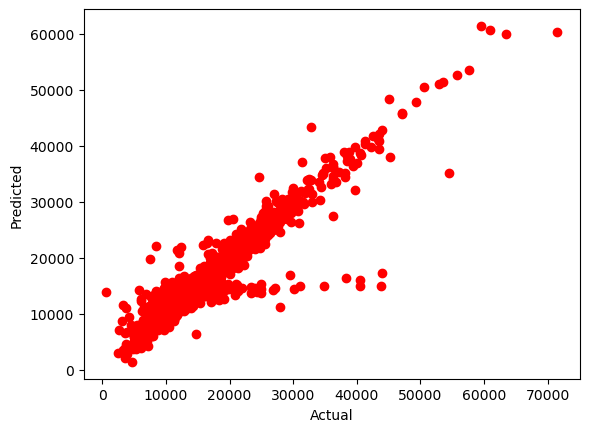

In [17]:
import matplotlib.pyplot as plt

plt.plot(y_test, X_predict, 'ro')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

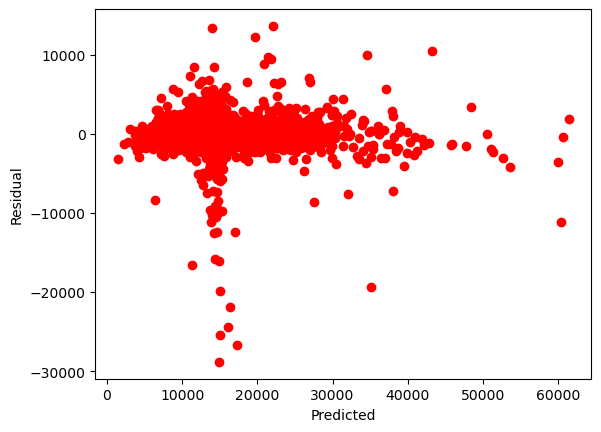

In [38]:
plt.plot(X_predict, X_predict - y_test, 'ro')
plt.ylabel('Residual')
plt.xlabel('Predicted')
plt.show()

Insert description here.

## Question 7: Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the $R^2$?

In [42]:
from sklearn.linear_model import Ridge
from collections import defaultdict
alphas = [0, 50, 100]

ridge_results = defaultdict(dict)

for alph in alphas:
    modeling_pipeline_ridge = Pipeline([('data_processing', processing_pipeline), ('ridge', Ridge(alpha=alph))])
    modeling_pipeline_ridge.fit(X_train, y_train)
    ridge_results['coefficients'][alph] = modeling_pipeline_ridge['ridge'].coef_
    ridge_results['training score'][alph] = modeling_pipeline_ridge.score(X_train, y_train)
    ridge_results['test score'][alph] = modeling_pipeline_ridge.score(X_test, y_test)

print('Done')

Done


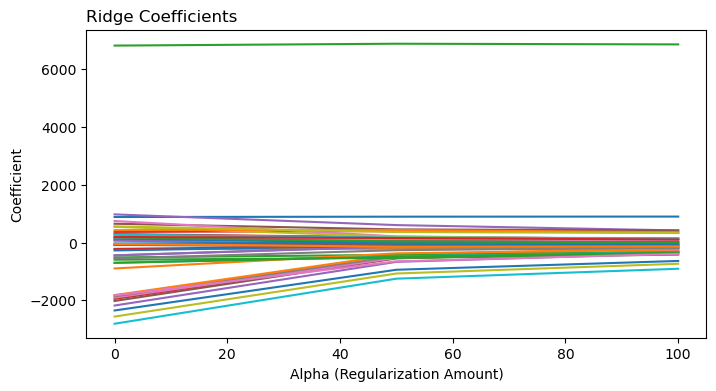

In [43]:
coefficients_ridge = pd.DataFrame.from_dict(ridge_results['coefficients'])
coefficients_ridge = coefficients_ridge.reset_index()
coefficients_ridge = coefficients_ridge.rename(columns={'index':'coefficient_nbr'})
coefficients_ridge = coefficients_ridge.melt(id_vars='coefficient_nbr', var_name='alpha', value_name='coefficient')

(
coefficients_ridge.pivot_table(index='alpha', columns='coefficient_nbr', values='coefficient')
    .plot(figsize=(8,4),legend=False)
)

plt.title('Ridge Coefficients', loc='left')
plt.xlabel('Alpha (Regularization Amount)')
plt.ylabel('Coefficient')
plt.show()

### Changes in R-Square

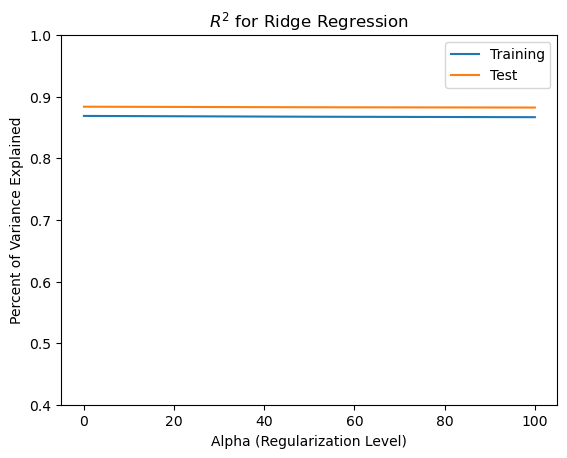

In [44]:
ridge_training_r2 = pd.Series(ridge_results['training score'])
ridge_test_r2 = pd.Series(ridge_results['test score'])

ridge_training_r2.plot()
ridge_test_r2.plot()
plt.title('$R^2$ for Ridge Regression')
plt.legend(['Training','Test'])
plt.xlabel('Alpha (Regularization Level)')
plt.ylabel('Percent of Variance Explained')
plt.ylim(0.4, 1)
plt.show()